In [176]:
import os
import pprint
import json
import time
from datetime import timedelta
import numpy as np
import pandas as pd

# DB Import
import pymongo
import redis
import neo4j

# Visualization
from scipy.stats import norm, stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Data Load

In [198]:
data_folder_name = 'data'
data_file_name = 'SP500_2020_2025.csv'
cleaned_data_path = os.path.join(os.getcwd(), os.path.pardir, data_folder_name, data_file_name)

def get_sp500_dataset(cleaned_data_path):
    if os.path.exists(cleaned_data_path):
        return pd.read_csv(cleaned_data_path)
    else:
        print('Downloading S&P 500 Stock data,,, (Nov 2025)')
        tickers = [
            'AAPL','MSFT','NVDA','GOOGL','AMZN','META','TSLA','LLY','AVGO','JPM','BRK-B','XOM','UNH','V','MA',
            'PG','JNJ','HD','MRK','COST','ABBV','CRM','NFLX','AMD','ADBE','WMT','KO','TMO','CVX','ACN','LIN',
            'MCD','PEP','ORCL','CSCO','GE','ABT','QCOM','INTU','VZ','AMAT','PFE','DIS','TXN','NOW','UNP','RTX',
            'PGR','CAT','ISRG','SPGI','BKNG','HON','ETN','SYK','VRTX','REGN','LRCX','BLK','BSX','ELV','ADP','MDT',
            'PLD','KLAC','PANW','ADI','TJX','CB','SBUX','GILD','ANET','BX','CME','MU','AMT','FI','SO','BMY','DE',
            'MO','NEE','TMUS','SCHW','ZTS','SHW','WM','T','DUK','ITW','APH','CL','ICE','BA','MMM','BDX','GD','EOG',
            'HCA','CTAS','FCX','EMR','NOC','PYPL','MCK','CDNS','TT','PNC','FDX','ECL','WELL','ORLY','RSG','AJG',
            'COF','CARR','CPRT','AON','AZO','MSI','EW','MCHP','TFC','KDP','AFL','ADSK','O','ROP','PSX','FTNT',
            'PAYX','GWW','DXCM','NUE','TEL','OKE','HUM','KMB','IDXX','DHI','STZ','AEP','SRE','IQV','CTSH','MSCI',
            'ROST','FAST','JCI','VLO','EXC','LHX','CTVA','FICO','ODFL','LEN','BKR','AMP','PRU','PCAR','VRSK','VMC',
            'MLM','CSX','EA','DLR','XEL','ED','WST','TRGP','YUM','EXR','HES','CTRA','WEC','TSCO','PPG','EFX','DD',
            'CBRE','HSY','VICI','MTD','ANSS','RCL','DAL','WAB','XYL','ON','EIX','AVB','ROK','CDW','RMD','DFS','TROW',
            'DOV','VLTO','HIG','WBD','DG','MPWR','LYB','GPC','FTV','BR','HUBB','WY','VEEV','CHD','TTWO','IRM','ZBH',
            'PH','WDC','BALL','STE','ALGN','AXON','INVH','TRU','MOH','ULTA','DRI','CNC','FE','STT','BRO','FITB','MKC',
            'WRB','CAG','TDY','HBAN','RF','ETR','NTAP','LH','JBHT','LUV','PFG','ATO','TXT','NVR','PKG','CBOE','EXPD',
            'CINF','HOLX','J','SWKS','VTRS','K','AVY','SNA','BBY','ESS','ILMN','TER','ENPH','LDOS','MAA','WAT','COO',
            'TSN','ARE','CEG','KEYS','UAL','TYL','CMS','PPL','IP','ALB','LNT','FDS','BG','DPZ','MGM','CF','EQR','HPE',
            'PTC','L','CCL','ROL','KIM','DOC','SYF','LKQ','HST','AEE','RVTY','NRG','AKAM','POOL','TAP','BEN','TECH',
            'AES','EVRG','REG','TRMB','IEX','JNPR','UDR','NDAQ','KMX','INCY','BAX','LW','CPT','UHS','PEAK','MAS','BBWI',
            'ALLE','FFIV','AOS','CHRW','TFX','EMN','GL','IPG','JKHY','NDSN','HII','CRL','PNR','AIZ','HAS','BXP','FRT',
            'GNRC','APA','NCLH','CZR','IVZ','FOXA','FOX','MHK','PARA','NWS','NWSA'
        ]

        all_dfs = []
        for ticker in tqdm(tickers):          # ← plain tqdm = no ipywidgets error
            try:
                data = yf.Ticker(ticker).history(period="5y", auto_adjust=True, actions=False)
                if data.empty or len(data) < 200:
                    continue
                df = data[['Open','High','Low','Close','Volume']].round(2)
                df['Ticker'] = ticker
                df = df.reset_index()
                all_dfs.append(df)
            except Exception as e:
                print(f"  → Failed {ticker}: {e}")
            time.sleep(0.3)   # be nice to Yahoo

        # Combine & save
        final = pd.concat(all_dfs, ignore_index=True)
        final = final[['Date','Ticker','Open','High','Low','Close','Volume']]
        final = final.sort_values(['Date','Ticker']).reset_index(drop=True)

        path = Path(cleaned_data_path).expanduser()
        final.to_csv(path, index=False)

        print(f"\nDONE! {len(final):,} rows | {final['Ticker'].nunique()} tickers")
        print(f"Saved → {path.name}")
        return final
        
df = get_sp500_dataset(cleaned_data_path)
df.head()

,Date,Ticker,Open,High,Low,Close,Volume
0,2020-12-03 00:00:00-05:00,AAPL,120.24,120.49,118.97,119.68,78967600
1,2020-12-03 00:00:00-05:00,ABBV,86.40,86.98,85.83,86.19,4693600
2,2020-12-03 00:00:00-05:00,ABT,98.81,99.26,97.83,98.24,3846300
3,2020-12-03 00:00:00-05:00,ACN,232.70,234.29,231.64,232.63,1552300
4,2020-12-03 00:00:00-05:00,ADBE,482.21,492.81,481.50,484.28,3062700


In [199]:
number_of_ticker_over_two_rows = sum(df.groupby(['Date','Ticker'])['Close'].nunique().reset_index()['Close']!=1)
print(f'There are Ticker over 2 rows by a day: {number_of_ticker_over_two_rows}')

There are Ticker over 2 rows by a day: 0


In [200]:
stale_data = df[df.Date < '2025-01-01'].reset_index(drop=True)
new_data = df[df.Date >= '2025-01-01'].reset_index(drop=True)
new_data.tail()

,Date,Ticker,Open,High,Low,Close,Volume
77732,2025-12-02 00:00:00-05:00,XOM,116.44,116.60,114.69,115.38,14606100
77733,2025-12-02 00:00:00-05:00,XYL,139.90,140.44,138.59,139.42,1191600
77734,2025-12-02 00:00:00-05:00,YUM,150.89,151.00,146.94,147.62,1781300
77735,2025-12-02 00:00:00-05:00,ZBH,95.85,96.06,93.90,94.14,1536400
77736,2025-12-02 00:00:00-05:00,ZTS,126.00,126.00,122.52,124.44,6896900


# Load Raw Data to MongoDB

In [132]:
client = pymongo.MongoClient("mongodb://mongo:27017/")
db_list = client.list_database_names()
db_list

['acme_gourmet_meals', 'admin', 'config', 'local', 'sp500']

In [133]:
# DB / Collection
db = client["sp500"]           # DB name: sp500
collection = db["prices"]      # Collection name: prices

# dictionarize by row -> list[dict] 
records = stale_data.to_dict("records")

# if wanna delete prior collection and insert again
collection.delete_many({})

# 6) MongoDB insert
result = collection.insert_many(records)

print(f"Inserted {len(result.inserted_ids)} documents into MongoDB.")

Inserted 345455 documents into MongoDB.


# MongoDB to Neo4j

### 1. Read Raw Data from MongoDB & Preprocess

In [134]:
client = pymongo.MongoClient("mongodb://mongo:27017/")
db = client["sp500"]          
prices_collection = db["prices"]           

cursor = prices_collection.find({}, {"_id": 0})
df = pd.DataFrame(list(cursor))

print(f"Data Sample from MongoDB: {len(df)} rows")
df.head()

Data Sample from MongoDB: 345455 rows


,Date,Ticker,Open,High,Low,Close,Volume
0,2020-12-03 00:00:00-05:00,AAPL,120.24,120.49,118.97,119.68,78967600
1,2020-12-03 00:00:00-05:00,ABBV,86.40,86.98,85.83,86.19,4693600
2,2020-12-03 00:00:00-05:00,ABT,98.81,99.26,97.83,98.24,3846300
3,2020-12-03 00:00:00-05:00,ACN,232.70,234.29,231.64,232.63,1552300
4,2020-12-03 00:00:00-05:00,ADBE,482.21,492.81,481.50,484.28,3062700


In [135]:
def get_daily_return(df):
    df["return"] = np.log(df["Close"]) - np.log(df["Open"])
    df = df.dropna(subset=["return"])
    return df

def pivot_return(df):
    # pivot: row = Date, col = Ticker, value = return
    pivot = df.pivot(index="Date", columns="Ticker", values="return")
    pivot = pivot.dropna(axis=0, how="any")
    return pivot

In [136]:
df = get_daily_return(df)
df.head()

,Date,Ticker,Open,High,Low,Close,Volume,return
0,2020-12-03 00:00:00-05:00,AAPL,120.24,120.49,118.97,119.68,78967600,-0.004668
1,2020-12-03 00:00:00-05:00,ABBV,86.40,86.98,85.83,86.19,4693600,-0.002434
2,2020-12-03 00:00:00-05:00,ABT,98.81,99.26,97.83,98.24,3846300,-0.005785
3,2020-12-03 00:00:00-05:00,ACN,232.70,234.29,231.64,232.63,1552300,-0.000301
4,2020-12-03 00:00:00-05:00,ADBE,482.21,492.81,481.50,484.28,3062700,0.004284


In [138]:
return_wide = pivot_return(df)

# Correlation matrix across tickers
corr = return_wide.corr()

print(f'{corr.shape=}')
corr.head()

corr.shape=(338, 338)


Ticker,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,ADSK,AEE,AEP,...,WMT,WRB,WST,WY,XEL,XOM,XYL,YUM,ZBH,ZTS
Ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,1.000000,-0.040037,-0.088636,0.207881,0.249729,0.258656,0.070372,0.315191,-0.039127,-0.039146,...,0.054619,-0.040211,0.135255,0.095968,-0.075039,-0.129303,0.195450,0.071900,-0.022642,0.091937
ABBV,-0.040037,1.000000,0.331034,0.047165,0.006987,0.051739,0.312573,0.126065,0.255972,0.316179,...,0.207325,0.216276,0.188626,0.310094,0.246578,0.235623,0.164943,0.250304,0.286485,0.156449
ABT,-0.088636,0.331034,1.000000,0.069512,-0.059624,0.107540,0.316224,0.090331,0.287830,0.318601,...,0.107222,0.168508,0.079599,0.263325,0.300204,0.079343,0.224286,0.273598,0.449964,0.298501
ACN,0.207881,0.047165,0.069512,1.000000,0.314299,0.263700,0.220281,0.304678,0.136506,0.110523,...,0.182984,0.140420,0.157120,0.120876,0.096261,0.008593,0.161261,0.143794,0.155305,0.206683
ADBE,0.249729,0.006987,-0.059624,0.314299,1.000000,0.288881,0.203390,0.421418,-0.022508,-0.039252,...,0.083949,0.036011,0.100283,0.025794,-0.046511,-0.090697,0.165574,0.049329,0.072477,0.066544


In [139]:
def get_edges_by_threshold(corr, threshold=0.6):
    new_corr = corr.rename_axis(index="src", columns="dst")
    edges = (
        new_corr.where(lambda x: x.abs() >= threshold)   
            .stack()                                 # stack by index(src, dst)
            .reset_index()                           
            .rename(columns={0: "corr"})
    )

    edges = edges[edges["src"] < edges["dst"]]
    edges = edges.reset_index(drop=True)
    return edges

In [140]:
threshold = 0.6
edges = get_edges_by_threshold(corr, threshold=threshold)
print(f'Created edges number by {threshold=} : {len(edges)}')
edges.head()

Created edges number by threshold=0.6 : 350


,src,dst,corr
0,ADI,AMAT,0.614442
1,ADI,KLAC,0.630897
2,ADI,LRCX,0.617912
3,ADI,MCHP,0.765058
4,ADI,MPWR,0.683405


### 2. Load Data to Neo4j

In [113]:
# To get driver, use 7687 port(Bolt)
driver = neo4j.GraphDatabase.driver(uri="neo4j://neo4j:7687", auth=("neo4j","ucb_mids_w205"))

In [114]:
def create_schema(tx):
    # Stock label name unique constraint
    # CONSTRAINT to name → create index in name var.
    tx.run("""
        CREATE CONSTRAINT IF NOT EXISTS
        FOR (s:Stock)
        REQUIRE s.name IS UNIQUE
    """)

def create_stock_nodes(tx, names):
    # MERGE : 그 name을 가진 node가 없으면 생성, 있으면 재사용
    # (s:Stock {name: "AAPL"})
    tx.run("""
        UNWIND $names AS received_name
        MERGE (s:Stock {name: received_name})
    """, names=names)

def create_correlation_edges(tx, edge_list):
    # ()-[]-() : undirected, ()-[]->() : directed
    tx.run("""
        UNWIND $edge_list AS edge
        MATCH (a:Stock {name: edge.src})
        MATCH (b:Stock {name: edge.dst})
        MERGE (a)-[r:CORRELATED]-(b)
        SET r.corr = edge.corr
    """, edge_list=edge_list)
    
def batch(iterable, batch_size=1000):
    for i in range(0, len(iterable), batch_size):
        yield iterable[i:i+batch_size]

In [115]:
with driver.session(database="neo4j") as session:
    # Create Schema
    session.execute_write(create_schema)

    # Create Nodes
    tickers = df["Ticker"].unique().tolist()
    session.execute_write(create_stock_nodes, tickers)

    # Create Edges
    edge_records = edges[["src", "dst", "corr"]].to_dict("records")
    print("Edge number to load to Neo4j:", len(edge_records))

    # If data get larger, upload by batch_size will be needed
    batch_size = 1000
    for i, chunk in enumerate(batch(edge_records, batch_size)):
        session.execute_write(create_correlation_edges, chunk)
        print(f"{(i+1) * len(chunk)} / {len(edge_records)} edges loaded")

Edge number to load to Neo4j: 350
350 / 350 edges loaded


### 3. GDS Algorithms

In [22]:
def my_neo4j_run_query_pandas(query, **kwargs):
    "run a query and return the results in a pandas dataframe"
    
    result = session.run(query, **kwargs)
    
    df = pd.DataFrame([r.values() for r in result], columns=result.keys())
    
    return df

#### 3.1 Create Graph sp500_graphg

In [116]:
with driver.session(database="neo4j") as session:
    # Use Neo4j Internal Graph Data-Science(GDS) Algorithm Lib.
    query = "CALL gds.graph.drop('sp500_graph', false) yield graphName"
    session.run(query)

    query = """
        CALL gds.graph.project(
            'sp500_graph', 
            'Stock', 
            {
                CORRELATED: 
                    {
                        orientation: 'UNDIRECTED',
                        properties: 'corr'
                    }
            }
        )
    """
    session.run(query)

#### 3.2 Use Louvain Modularity to Obtain Community

In [117]:
with driver.session(database="neo4j") as session:
    louvain_stats = my_neo4j_run_query_pandas("""
        CALL gds.louvain.write('sp500_graph', 
            {
                relationshipWeightProperty: 'corr',
                writeProperty: 'community'
            }
        )
        YIELD communityCount, modularity
        RETURN communityCount, modularity
    """
    )
display(louvain_stats)

,communityCount,modularity
0,163,0.745825


In [118]:
with driver.session(database="neo4j") as session:
    communities = my_neo4j_run_query_pandas("""
        MATCH (s:Stock)
        WITH 
            s.community AS community,
            collect(s.name) AS tickers,
            count(*) AS size
        WHERE size > 1
        RETURN community, tickers, size
        ORDER BY community, size
    """)

communities_sorted = communities.sort_values("size", ascending=False)
print(f'Unique Communities Counts without sigleton: {len(communities_sorted)}')
display(communities_sorted)


Unique Communities Counts without sigleton: 35


,community,tickers,size
22,280,"[ALLE, AMP, AOS, BEN, BLK, BX, CARR, CAT, COF,...",40
14,223,"[ADI, AMAT, AMD, ANET, APH, AVGO, CDNS, CDW, C...",27
3,109,"[AMT, ARE, AVB, BXP, CBRE, CPT, DOC, EQR, ESS,...",21
4,115,"[AEE, AEP, AES, ATO, CMS, DUK, ED, EIX, ETR, E...",19
9,183,"[DD, DHI, EMN, HD, LEN, LYB, MAS, MHK, NVR, PO...",12
20,253,"[APA, BKR, CTRA, CVX, EOG, OKE, PSX, TRGP, VLO...",10
8,181,"[AFL, AIZ, BRK-B, CB, CINF, HIG, L, WRB]",8
32,322,"[CRL, IQV, MTD, RVTY, TECH, TMO, WAT]",7
7,180,"[CHD, CL, KMB, KO, PEP, PG]",6
26,305,"[CCL, DAL, NCLH, RCL, UAL]",5


#### 3.2.1 Community Debugging

In [264]:
# ----------------------------
# 1. Load SP500 sector mapping
# ----------------------------
sector_mapping = pd.read_csv(
    "https://raw.githubusercontent.com/datasets/s-and-p-500-companies/master/data/constituents.csv"
)

sector_mapping = sector_mapping.rename(columns={
    "Symbol": "ticker",
    "GICS Sector": "sector",
    "GICS Sub-Industry": "sub_industry"
})[["ticker", "sector", "sub_industry"]]


# ----------------------------
# 2. Pull ticker → community from Neo4j
# ----------------------------
with driver.session(database="neo4j") as session:
    communities = my_neo4j_run_query_pandas("""
        MATCH (s:Stock)
        RETURN s.name AS ticker,
               s.community AS community
        """
    )


# ----------------------------
# 3. Merge communities with GICS metadata
# ----------------------------
merged = communities.merge(sector_mapping, on="ticker", how="left")


# ----------------------------
# 4. Compute dominant sector & purity
# ----------------------------
sector_stats = (
    merged
        .dropna(subset=['sector'])
        .groupby("community")["sector"]
        .agg(lambda x: x.value_counts().idxmax())        # dominant sector
        .reset_index()
        .rename(columns={"sector": "dominant_sector"})
)

sector_purity = (
    merged.groupby(["community", "sector"]).size()
          .groupby(level=0).apply(lambda x: x.max() / x.sum())
          .reset_index(name="sector_purity")
)


# ----------------------------
# 5. Compute dominant sub-industry & purity
# ----------------------------
sub_stats = (
    merged
        .dropna(subset=['sub_industry'])
        .groupby('community')['sub_industry']
        .agg(lambda x: x.mode().iloc[0])
        .reset_index()
        .rename(columns={"sub_industry": "dominant_sub_industry"})
)

sub_purity = (
    merged.groupby(["community", "sub_industry"]).size()
          .groupby(level=0).apply(lambda x: x.max() / x.sum())
          .reset_index(name="subindustry_purity")
)

# ----------------------------
# 6. Compute community sizes
# ----------------------------
sizes = merged.groupby("community").size().reset_index(name="size")

# ----------------------------
# 7. Combine everything into one summary table
# ----------------------------
summary = (
    sector_stats
    .merge(sub_stats, on="community")
    .merge(sizes, on="community")
    .merge(sector_purity, on="community")
    .merge(sub_purity, on="community")
    .sort_values("size", ascending=False)
)

summary_sorted = summary.sort_values(
    ["size", "sector_purity", "subindustry_purity"],
    ascending=[False, False, False]
)

display(summary_sorted)

,community,dominant_sector,dominant_sub_industry,size,sector_purity,subindustry_purity
127,280,Industrials,Industrial Machinery & Supplies & Components,40,0.500000,0.250000
102,223,Information Technology,Semiconductors,27,0.814815,0.407407
42,109,Real Estate,Multi-Family Residential REITs,21,1.000000,0.285714
44,115,Utilities,Electric Utilities,19,1.000000,0.578947
81,183,Consumer Discretionary,Specialty Chemicals,12,0.500000,0.416667
...,...,...,...,...,...,...
56,135,Financials,Life & Health Insurance,1,1.000000,1.000000
57,136,Industrials,Electrical Components & Equipment,1,1.000000,1.000000
58,138,Consumer Discretionary,Distributors,1,1.000000,1.000000
59,140,Consumer Discretionary,Leisure Products,1,1.000000,1.000000


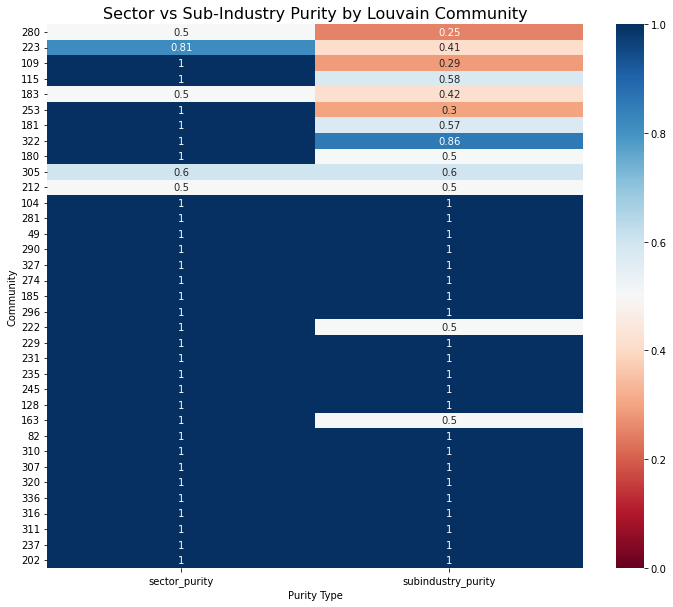

In [265]:
plt.figure(figsize=(12, 10))
analyze_summary = summary[summary['size']>1].reset_index(drop=True)
sns.heatmap(
    analyze_summary[["sector_purity", "subindustry_purity"]].set_index(analyze_summary["community"]),
    annot=True,
    cmap="RdBu",
    vmin=0.0,
    vmax=1.0
)
plt.title("Sector vs Sub-Industry Purity by Louvain Community", fontsize=16)
plt.xlabel("Purity Type")
plt.ylabel("Community")
plt.show()


The purity analysis reveals important insights into how market behavior aligns—and diverges—from the official GICS sector classifications. Many Louvain communities show high sector and sub-industry purity, indicating that stocks within these clusters tend to move together in a manner consistent with their fundamental sector definitions. Sectors such as Utilities, Real Estate, Energy, Financials, Consumer Staples, and large parts of Health Care demonstrate extremely coherent price-movement behavior, which is reflected in purity scores close to 1.0. These high-purity clusters represent segments of the market that are both fundamentally cohesive and behaviorally cohesive.

However, not all communities display perfect purity. Several clusters exhibit mixed-sector composition, most notably within Industrials and Consumer Discretionary, which show lower purity values. These sectors are broad and heterogeneous by design, containing companies with widely varying business models, revenue drivers, macro sensitivities, and volatility profiles. For example, Industrials includes aerospace, machinery, airlines, logistics, and multi-industry conglomerates—groups that do not necessarily co-move. Consumer Discretionary spans retail, autos, travel, lodging, apparel, and e-commerce, which react differently to interest rates, seasonality, and consumer demand shocks. As a result, Louvain naturally segments these sectors into multiple behavioral clusters. The presence of multiple “Health Care,” “Industrials,” or “Communication Services” clusters does not indicate an error; rather, it highlights finer-grained behavioral substructure within sectors that GICS classifications do not explicitly capture.

The heatmap provides a visual summary of this pattern. High-purity communities appear as dark blue, saturated regions (near 1.0), while lower-purity communities appear as darker red regions. The heatmap makes immediately clear which communities correspond closely to fundamental sectors and which reflect cross-sector or sub-industry blending. It also highlights where Louvain has uncovered statistical clusters that differ from the fundamental clusters defined by GICS. Importantly, this visualization underscores that sector purity is not merely a classification exercise—it reflects actual co-movement and correlation dynamics in the market. In doing so, the heatmap illustrates both the strengths and limitations of sector-based classification systems and the value of unsupervised, data-driven clustering approaches in capturing the true structure of financial markets. Overall, the purity results and the accompanying heatmap demonstrate that while fundamental sectors provide a useful high-level grouping, behavioral clustering reveals a more nuanced and accurate picture of how stocks actually move together, identifying both tightly knit sector cores and complex, blended regions where cross-sector interactions dominate.

#### 3.3 Use PageRank to measure node's importance

In [142]:
query_write = """
    CALL gds.pageRank.write('sp500_graph',
          {
            maxIterations: $max_iterations,
            dampingFactor: $damping_factor,
            writeProperty: 'pagerank'
          }
    )
    YIELD nodePropertiesWritten, ranIterations, didConverge
    RETURN nodePropertiesWritten, ranIterations, didConverge
"""

max_iterations = 20
damping_factor = 0.7
with driver.session(database="neo4j") as session:
    pr_write_result = my_neo4j_run_query_pandas(
        query_write,
        max_iterations=max_iterations,
        damping_factor=damping_factor
    )
pr_write_result

,nodePropertiesWritten,ranIterations,didConverge
0,338,20,False


#### 3.4 Use Betweenness to identify cross-community bridge nodes

In [144]:
query_write = """
    CALL gds.betweenness.write('sp500_graph', 
        {
            writeProperty: 'betweenness'
        }
    )
    YIELD nodePropertiesWritten
    RETURN nodePropertiesWritten
"""
with driver.session(database="neo4j") as session:
    between_write_df = my_neo4j_run_query_pandas(query_write)
between_write_df

,nodePropertiesWritten
0,338


### 4. Making Pipeline for Daily Data

#### 4.1 Get Node's trained Information and Save

In [243]:
with driver.session(database="neo4j") as session:
    ticker_information = my_neo4j_run_query_pandas("""
        MATCH (s:Stock)
        RETURN s.name AS Ticker,
               s.community AS community,
               s.pagerank AS page_rank,
               s.betweenness AS betweenness
    """)

display(ticker_information)

ticker_information_path = os.path.join(os.getcwd(), os.path.pardir, data_folder_name, 'ticker_information.csv')
ticker_information.to_csv(ticker_information_path, index=False)

,Ticker,community,page_rank,betweenness
0,AAPL,0,0.300000,0.000000
1,ABBV,1,0.300000,0.000000
2,ABT,2,0.300000,0.000000
3,ACN,82,0.999202,0.000000
4,ADBE,4,0.300000,0.000000
...,...,...,...,...
333,XOM,253,1.187991,3.666667
334,XYL,223,0.389189,0.000000
335,YUM,335,0.300000,0.000000
336,ZBH,336,0.999202,0.000000


#### 4.2 Making Pipeline after 2025-01-01, monitoring data day-by-day and applying Kafka

In [293]:
ticker_information = pd.read_csv(ticker_information_path)

In [294]:
ticker_information["pr_pct_rank_in_comm"] = (
                        ticker_information
                        .groupby("community")["page_rank"]
                        .rank(pct=True)
)

Top 10% Tickers: ['PH' 'VICI']
Bottom 5% Tickers: ['AAPL' 'ABBV' 'ABT' 'ACN' 'ADBE' 'ADI' 'ADP' 'ADSK' 'AEE' 'AES' 'AFL'
 'AIZ' 'AJG' 'AKAM' 'ALB' 'ALGN' 'ALLE' 'AMD' 'AMT' 'AMZN' 'ANET' 'AON'
 'AOS' 'APA' 'ARE' 'ATO' 'AVB' 'AVGO' 'AVY' 'AXON' 'AZO' 'BA' 'BALL' 'BAX'
 'BBWI' 'BBY' 'BDX' 'BEN' 'BG' 'BKNG' 'BKR' 'BLK' 'BMY' 'BR' 'BRK-B' 'BRO'
 'BSX' 'CAG' 'CAT' 'CB' 'CBOE' 'CBRE' 'CCL' 'CDNS' 'CDW' 'CF' 'CHD' 'CHRW'
 'CINF' 'CL' 'CME' 'CMS' 'CNC' 'COF' 'COO' 'COST' 'CPRT' 'CPT' 'CRL' 'CRM'
 'CSCO' 'CSX' 'CTAS' 'CTRA' 'CTSH' 'CTVA' 'CVX' 'CZR' 'DAL' 'DD' 'DE' 'DG'
 'DHI' 'DIS' 'DLR' 'DOC' 'DPZ' 'DRI' 'DUK' 'DXCM' 'EA' 'ECL' 'ED' 'EFX'
 'ELV' 'ENPH' 'EOG' 'EQR' 'ESS' 'ETR' 'EVRG' 'EW' 'EXC' 'EXPD' 'EXR'
 'FAST' 'FCX' 'FDS' 'FDX' 'FE' 'FFIV' 'FI' 'FICO' 'FOX' 'FOXA' 'FTNT'
 'FTV' 'GD' 'GE' 'GILD' 'GL' 'GNRC' 'GOOGL' 'GPC' 'HAS' 'HBAN' 'HCA' 'HD'
 'HII' 'HOLX' 'HON' 'HPE' 'HST' 'HSY' 'HUM' 'ICE' 'IDXX' 'IEX' 'ILMN'
 'INCY' 'INTU' 'INVH' 'IP' 'IPG' 'IQV' 'IRM' 'ISRG' 'J' 'JBHT' 'JCI'
 'JKHY' 

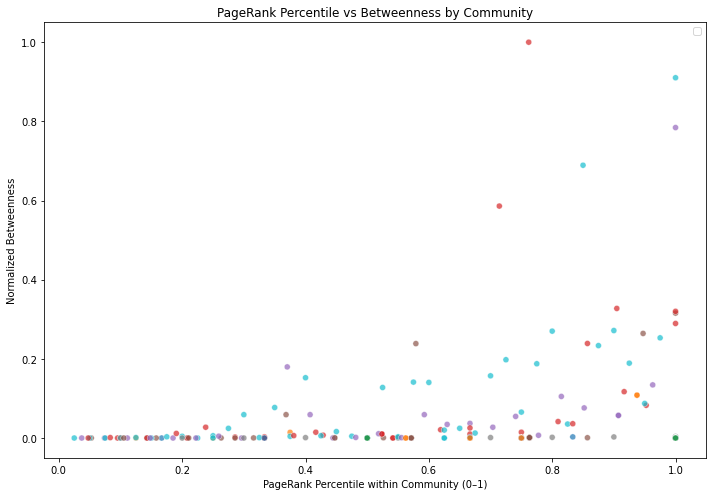

In [295]:
# Original Version
def _get_filtered_tickers_by_bet(df, hub_cut=0.9, fringe_cut=0.05):
    print(f'Top 10% Tickers: {df[(df["bet_norm"] > hub_cut)]["Ticker"].unique()}')
    print(f'Bottom 5% Tickers: {df[(df["bet_norm"] < fringe_cut)]["Ticker"].unique()}')
    
def plot_pr_vs_bet(df):
    tmp_df = _ensure_bet_norm(df)
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        data=tmp_df,
        x="pr_pct_rank_in_comm",
        y="bet_norm",
        hue="community",
        palette="tab10",
        alpha=0.7
    )
    
    _get_filtered_tickers_by_bet(tmp_df)
    plt.title("PageRank Percentile vs Betweenness by Community")
    plt.xlabel("PageRank Percentile within Community (0–1)")
    plt.ylabel("Normalized Betweenness")
    plt.legend('')
    plt.tight_layout()
    plt.show()
    
# df_prb = DataFrame with ['Ticker','community','pagerank','betweenness']
plot_pr_vs_bet(ticker_information)

There are companies like Google and Apple in the bottom 5% of betweenness. They have extremely large market capitalizations and are directly connected to many other stocks. Because of this dense internal connectivity, they do not need to act as bridges between communities, which naturally results in lower betweenness scores. Additionally, genuinely isolated nodes also fall into the bottom 5% of betweenness.

However, since our business objective is to identify laggards within each community, we should not remove these lower-ranked names. Internally central hubs like Google and Apple are actually critical targets for this strategy.

Among the top 10% betweenness group, we found only two tickers — PH and VICI. PH functions as a major industrial supply-chain hub, while VICI acts as a cross-sector real-estate connector. Because our business objective is to identify **laggards within communities**, such high-betweenness nodes can introduce noise because they reflect cross-community structural influence rather than intra-community performance divergence.

Therefore, we decided to exclude these high-betweenness tickers from the recommendation model. Removing these nodes helps the model focus on internal community dynamics rather than global network influence.

In [296]:
def visualize_number_of_ticker_per_comm(left_series, right_series):
    '''
    Compare Original vs. Stocks with PageRank Percentile ≥ 0.5 in Each Community
    '''
    figsize=(14, 5)
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    # Left Bar Chart
    left_series.plot(kind='bar', ax=axes[0])
    axes[0].set_xlabel("Community")
    axes[0].set_ylabel("Count")
    axes[0].grid(axis='y', linestyle='--', alpha=0.5)

    # Right Bar Chart
    right_series.plot(kind='bar', ax=axes[1], color='orange')
    axes[1].set_xlabel("Community")
    axes[1].set_ylabel("Count")
    axes[1].grid(axis='y', linestyle='--', alpha=0.5)
    
    plt.suptitle('Number of Tickers per Community')
    plt.tight_layout()
    plt.show()

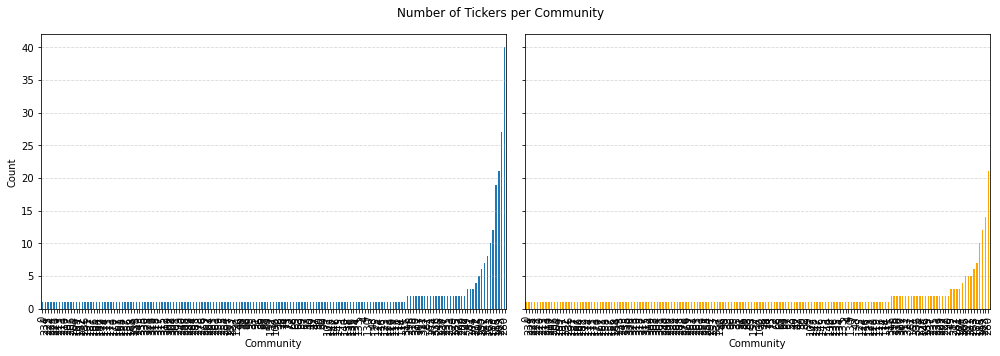

In [297]:
left_series = ticker_information.groupby('community')['Ticker'].count().sort_values()

core_tickers_information = ticker_information[ticker_information["pr_pct_rank_in_comm"] >= 0.5]
right_series = core_tickers_information.groupby('community')['Ticker'].count().sort_values()

visualize_number_of_ticker_per_comm(left_series, right_series)

In [298]:
core_tickers_information

,Ticker,community,page_rank,betweenness,pr_pct_rank_in_comm
0,AAPL,0,0.300000,0.000000,1.00
1,ABBV,1,0.300000,0.000000,1.00
2,ABT,2,0.300000,0.000000,1.00
3,ACN,82,0.999202,0.000000,0.75
4,ADBE,4,0.300000,0.000000,1.00
...,...,...,...,...,...
331,WY,109,1.485278,612.819001,1.00
333,XOM,253,1.187991,3.666667,0.80
335,YUM,335,0.300000,0.000000,1.00
336,ZBH,336,0.999202,0.000000,0.75


We can make the number of tickers across communities more balanced.

In [299]:
stock_redis = redis.Redis(host='redis', port=6379, db=0)
stock_redis.flushdb()

True

In [300]:
unique_dates = sorted(new_data['Date'].unique())

for date in unique_dates:
    daily = new_data[new_data['Date']==date].copy()
    daily = get_daily_return(daily)
    daily['abs_return'] = daily['return'].abs()
    
    # top_k approach
    daily = daily.merge(core_tickers_information, on='Ticker', how='inner')
    
    grouped = (
        daily.groupby("community")["abs_return"]
             .mean()
             .rename("community_avg_return")
             .reset_index()
    )
    enriched = daily.merge(grouped, on="community", how="left")
    under = enriched[enriched["abs_return"] < enriched["community_avg_return"]]
    date_str = date[:10]
    print(f'On {date_str}, the number of tickers that underperformed their community average return is {len(under)}.')
    
    key = f'under:{date_str}'  # under:2025-01-02
    payload = under[[
            'Ticker', 
            'community',
            'betweenness',
            'return',
            'abs_return', 
            'community_avg_return'
    ]].to_dict(orient='records')
    
    stock_redis.set(key, json.dumps(payload))
    
    # Do not use keys() because it block Redis
    all_keys = [k.decode() for k in stock_redis.scan_iter("under:*")]

    dates = [k.split(":", 1)[1] for k in all_keys]
    dates_sorted = sorted(dates, reverse=True)

    # leave only recent 5 days data
    keep = set(dates_sorted[:5])

    # delete rest
    for k in all_keys:
        if k.split(":", 1)[1] not in keep:
            stock_redis.delete(k)

On 2025-01-02, the number of tickers that underperformed their community average return is 73.
On 2025-01-03, the number of tickers that underperformed their community average return is 76.
On 2025-01-06, the number of tickers that underperformed their community average return is 76.
On 2025-01-07, the number of tickers that underperformed their community average return is 72.
On 2025-01-08, the number of tickers that underperformed their community average return is 81.
On 2025-01-10, the number of tickers that underperformed their community average return is 77.
On 2025-01-13, the number of tickers that underperformed their community average return is 78.
On 2025-01-14, the number of tickers that underperformed their community average return is 75.
On 2025-01-15, the number of tickers that underperformed their community average return is 77.
On 2025-01-16, the number of tickers that underperformed their community average return is 73.
On 2025-01-17, the number of tickers that underper

On 2025-05-15, the number of tickers that underperformed their community average return is 77.
On 2025-05-16, the number of tickers that underperformed their community average return is 82.
On 2025-05-19, the number of tickers that underperformed their community average return is 75.
On 2025-05-20, the number of tickers that underperformed their community average return is 78.
On 2025-05-21, the number of tickers that underperformed their community average return is 76.
On 2025-05-22, the number of tickers that underperformed their community average return is 79.
On 2025-05-23, the number of tickers that underperformed their community average return is 75.
On 2025-05-27, the number of tickers that underperformed their community average return is 78.
On 2025-05-28, the number of tickers that underperformed their community average return is 74.
On 2025-05-29, the number of tickers that underperformed their community average return is 75.
On 2025-05-30, the number of tickers that underper

On 2025-09-25, the number of tickers that underperformed their community average return is 76.
On 2025-09-26, the number of tickers that underperformed their community average return is 79.
On 2025-09-29, the number of tickers that underperformed their community average return is 74.
On 2025-09-30, the number of tickers that underperformed their community average return is 79.
On 2025-10-01, the number of tickers that underperformed their community average return is 82.
On 2025-10-02, the number of tickers that underperformed their community average return is 78.
On 2025-10-03, the number of tickers that underperformed their community average return is 76.
On 2025-10-06, the number of tickers that underperformed their community average return is 81.
On 2025-10-07, the number of tickers that underperformed their community average return is 77.
On 2025-10-08, the number of tickers that underperformed their community average return is 75.
On 2025-10-09, the number of tickers that underper

#### 4.x Check Cached Data through Redis 

In [301]:
for key in stock_redis.keys():
    print(key)

b'under:2025-11-28'
b'under:2025-11-25'
b'under:2025-12-01'
b'under:2025-12-02'
b'under:2025-11-26'


In [302]:
def load_last_5_days_from_redis(stock_redis):
    """
    under:YYYY-MM-DD format keys
    get recent 5days data
    """
    all_keys = [k.decode() for k in stock_redis.scan_iter("under:*")]
    if not all_keys:
        return pd.DataFrame()

    date_map = {}
    for k in all_keys:
        _, date_str = k.split(":", 1)
        date_map.setdefault(date_str, []).append(k)

    dates_sorted = sorted(date_map.keys(), reverse=True)
    last_5_dates = dates_sorted[:5]

    rows = []
    for d in last_5_dates:
        for k in date_map[d]:
            raw = stock_redis.get(k)
            if not raw:
                continue
            payload = json.loads(raw)
            for rec in payload:
                rec["date"] = d
                rows.append(rec)

    df = pd.DataFrame(rows)
    if df.empty:
        return df

    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values(["date", "community", "Ticker"]).reset_index(drop=True)
    return df

df_under = load_last_5_days_from_redis(stock_redis)
df_under

,Ticker,community,betweenness,return,abs_return,community_avg_return,date
0,AJG,49,0.00,0.001760,0.001760,0.010534,2025-11-25
1,BRO,49,0.00,0.009986,0.009986,0.010534,2025-11-25
2,CTSH,82,0.00,0.016087,0.016087,0.016602,2025-11-25
3,ELV,104,0.00,0.014166,0.014166,0.018848,2025-11-25
4,MOH,104,0.00,0.009309,0.009309,0.018848,2025-11-25
...,...,...,...,...,...,...,...
381,VZ,320,0.00,-0.003441,0.003441,0.007758,2025-12-02
382,RVTY,322,0.25,0.004097,0.004097,0.008627,2025-12-02
383,TMO,322,0.25,-0.002702,0.002702,0.008627,2025-12-02
384,WM,327,0.00,-0.007476,0.007476,0.008512,2025-12-02


In [303]:
def _ensure_bet_norm(df):
    """betweenness → bet_norm(0~1)."""
    df = df.copy()
    if "bet_norm" not in df.columns:
        max_b = df["betweenness"].max()
        df["bet_norm"] = df["betweenness"] / max_b if max_b > 0 else 0.0
    return df

def _add_gap(df):
    """gap = community_avg_return.abs() - abs_return"""
    df = df.copy()
    df["gap"] = df["community_avg_return"].abs() - df["abs_return"]
    return df

def _filter_by_bet_range(df, hub_cut=0.90):
    """filter extreme data by betweenness( ~ 90%)"""
    df = df.copy()
    return df[(df["bet_norm"] <= hub_cut)]

In [304]:
def summarize_laggards_last_5_days_with_bet(
    df_under,
    hub_cut=0.90     # bet_norm base, top 10% delete (being lots of bridges of other nodes' shortest paths)
):
    if df_under.empty:
        return pd.DataFrame(), 0

    df = _ensure_bet_norm(df_under)
    df = _add_gap(df)
    df = _filter_by_bet_range(df, hub_cut=hub_cut)

    summary = (
        df.groupby("Ticker")
          .agg(
              under_days=("date", "nunique"),
              avg_gap=("gap", "mean"),
              avg_bet=("bet_norm", "mean"),
              last_return=("return", "last"),
              last_date=("date", "max")
          )
          .reset_index()
    )

    total_days = df["date"].nunique()
    summary["under_ratio"] = summary["under_days"] / total_days

    # normalization
    summary["under_days_norm"] = summary["under_days"] / summary["under_days"].max()
    summary["gap_norm"] = summary["avg_gap"] / summary["avg_gap"].max()

    # metrics:
    #  - more gap 
    #  - more under_days 
    #  - heading mid bet_norm is better → (1 - |bet_norm - 0.5|)
    summary["bet_middle_pref"] = 1 - (summary["avg_bet"] - 0.5).abs()

    summary["score"] = (
        0.5 * summary["gap_norm"] +
        0.3 * summary["under_days_norm"] +
        0.2 * summary["bet_middle_pref"]
    )

    summary = summary.sort_values("score", ascending=False)

    return summary, total_days

lag_summary, total_days = summarize_laggards_last_5_days_with_bet(df_under)
print(f"Top 20 laggards over the recent {total_days} days:")
lag_summary.head(20)

Top 20 laggards over the recent 5 days:


,Ticker,under_days,avg_gap,avg_bet,last_return,last_date,under_ratio,under_days_norm,gap_norm,bet_middle_pref,score
9,APH,5,0.011961,0.054560,-0.003598,2025-12-02,1.0,1.0,0.954610,0.554560,0.888217
106,QCOM,3,0.011959,0.006854,0.011489,2025-12-02,0.6,0.6,0.954470,0.506854,0.758606
90,NVDA,3,0.010685,0.010852,-0.001652,2025-12-02,0.6,0.6,0.852786,0.510852,0.708563
66,KLAC,5,0.007280,0.057111,0.016405,2025-12-02,1.0,1.0,0.581072,0.557111,0.701958
73,LRCX,5,0.006729,0.134212,0.014903,2025-12-02,1.0,1.0,0.537043,0.634212,0.695364
118,SYK,1,0.012529,0.000000,0.006366,2025-11-25,0.2,0.2,1.000000,0.500000,0.660000
12,AVGO,3,0.008435,0.027210,-0.017510,2025-12-02,0.6,0.6,0.673229,0.527210,0.622057
75,MAS,3,0.006537,0.320073,-0.006977,2025-12-02,0.6,0.6,0.521727,0.820073,0.604878
97,PFG,4,0.005480,0.187601,-0.000829,2025-12-01,0.8,0.8,0.437410,0.687601,0.596225
70,LEN,4,0.006324,0.000079,-0.001156,2025-12-02,0.8,0.8,0.504725,0.500079,0.592378


In [305]:
def pick_today_buy_candidates_with_bet(
    df_under,
    min_comm_return=0.005,
    top_k=3,
    hub_cut=0.90  
):
    if df_under.empty:
        return pd.DataFrame()

    df = _ensure_bet_norm(df_under)
    df = _add_gap(df)
    
    today = df["date"].max()
    today_df = df[df["date"] == today].copy()
    if today_df.empty:
        return pd.DataFrame()

    today_df = _filter_by_bet_range(today_df, hub_cut=hub_cut)

    candidates = []

    for comm, g in today_df.groupby("community"):
        comm_ret = g["community_avg_return"].abs().iloc[0]

        if comm_ret < min_comm_return:
            continue

        # Only increased tickers today
        g_pos = g[g["return"] > 0].copy()
        if g_pos.empty:
            continue

        # mid bet preference (peak around 0.5)
        g_pos["bet_middle_pref"] = 1 - (g_pos["bet_norm"] - 0.5).abs()

        # gap norm
        gap_max = g_pos["gap"].max()
        g_pos["gap_norm"] = g_pos["gap"] / gap_max if gap_max > 0 else 0

        # final score(LR)
        g_pos["score"] = (
            0.6 * g_pos["gap_norm"] +
            0.2 * g_pos["bet_norm"] +
            0.2 * g_pos["bet_middle_pref"]
        )

        top = g_pos.sort_values("score", ascending=False).head(top_k)
        candidates.append(top)

    if not candidates:
        return pd.DataFrame()

    result = pd.concat(candidates, ignore_index=True)

    return result.sort_values(["community", "score"], ascending=[True, False])

buy_today = pick_today_buy_candidates_with_bet(df_under)
print("Top 3 buy candidates by community as of today:")
buy_today

Top 3 buy candidates by community as of today:


,Ticker,community,betweenness,return,abs_return,community_avg_return,date,bet_norm,gap,bet_middle_pref,gap_norm,score
0,CTSH,82,0.000000,0.001159,0.001159,0.006786,2025-12-02,0.000000,0.005627,0.500000,1.000000,0.700000
1,ELV,104,0.000000,0.004149,0.004149,0.012402,2025-12-02,0.000000,0.008253,0.500000,1.000000,0.700000
2,MOH,104,0.000000,0.010122,0.010122,0.012402,2025-12-02,0.000000,0.002280,0.500000,0.276289,0.265773
3,ESS,109,21.384148,0.000729,0.000729,0.008055,2025-12-02,0.010098,0.007326,0.510098,1.000000,0.704039
4,UDR,109,21.384148,0.004695,0.004695,0.008055,2025-12-02,0.010098,0.003359,0.510098,0.458560,0.379175
5,EQR,109,44.282200,0.005176,0.005176,0.008055,2025-12-02,0.020911,0.002879,0.520911,0.392925,0.344119
6,PG,180,4.000000,0.003916,0.003916,0.010264,2025-12-02,0.001889,0.006348,0.501889,1.000000,0.700756
7,WRB,181,0.000000,0.003578,0.003578,0.005388,2025-12-02,0.000000,0.001810,0.500000,1.000000,0.700000
8,CB,181,0.000000,0.003981,0.003981,0.005388,2025-12-02,0.000000,0.001407,0.500000,0.777354,0.566413
9,POOL,183,31.075529,0.000940,0.000940,0.007436,2025-12-02,0.014674,0.006495,0.514674,1.000000,0.705870
